In [ ]:
# ======================
# Cell 0 — Kaggle-friendly setup
# ======================
# NOTE: Kaggle already has gymnasium & stable-baselines3. We avoid reinstalling them.
# If you need SHAP/LIME for explainability slides, uncomment the pip line below.

# !pip -q install shap==0.46.0 lime==0.2.0.1

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # silences most TF/XLA warnings

import warnings, os, sys
warnings.filterwarnings("ignore")

import gymnasium as gym
import stable_baselines3 as sb3
print("[env ok]", "gymnasium", gym.__version__, "| stable-baselines3", sb3.__version__)


E0000 00:00:1756635509.779461      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756635509.843752      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[env ok] gymnasium 0.29.0 | stable-baselines3 2.1.0


In [2]:
# ======================
# Cell 1 — Core imports
# ======================
from pathlib import Path
import json
import math
import random
import numpy as np
import pandas as pd

# RL
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.monitor import Monitor

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Typing
from typing import Dict, Tuple, List, Optional


In [3]:
# ======================
# Cell 2 — Paths & Config (for UCI multi-file dataset)
# ======================
from pathlib import Path
import numpy as np, random

# Root detection
DATA_ROOT  = Path("/kaggle/input") if Path("/kaggle/input").exists() else Path(".")
OUTPUT_DIR = Path("./outputs_clean"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Point directly to the folder with all patient files
DATA_DIR = DATA_ROOT/"dataset"/"diabetes-data"/"Diabetes-Data"
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Could not locate data folder at {DATA_DIR}")

print("DATA_DIR:", DATA_DIR)
print("Outputs ->", OUTPUT_DIR.resolve())

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED)

# RL settings
ALGO        = "PPO"      # or "DQN"
TOTAL_STEPS = 30_000
N_ENVS      = 1

# Discrete insulin adjustment actions
ACTIONS_MU   = [0, 1, 2, 3]
ACTION_LABEL = {0:"no-op", 1:"+low", 2:"+mid", 3:"+high"}

# Glycaemic bands
TIR_BOUNDS  = (70, 180)
HYPO_BOUND  = 70
HYPER_BOUND = 180

print("RL:", ALGO, "| total steps:", TOTAL_STEPS, "| action codes:", ACTIONS_MU)


DATA_DIR: /kaggle/input/dataset/diabetes-data/Diabetes-Data
Outputs -> /kaggle/working/outputs_clean
RL: PPO | total steps: 30000 | action codes: [0, 1, 2, 3]


In [4]:
# ======================
# Cell 3 — Load UCI diabetes dataset (multi-file format) + sanity checks
# ======================

import os
import pandas as pd
import matplotlib.pyplot as plt

# Folder with patient files
DATA_DIR = "/kaggle/input/dataset/diabetes-data/Diabetes-Data"

# All patient files start with "data-"
patient_files = sorted([f for f in os.listdir(DATA_DIR) if f.startswith("data-")])

dfs = []
for idx, fname in enumerate(patient_files, start=1):
    path = os.path.join(DATA_DIR, fname)
    
    # Each line: Date (MM-DD-YYYY), Time (HH:MM), Code, Value
    df_p = pd.read_csv(path, sep="\t", header=None, names=["date","time","code","value"], engine="python")
    
    # Add patient id
    df_p["patient_id"] = idx
    
    # Drop completely empty rows (some files have blanks)
    df_p = df_p.dropna(how="all")
    
    dfs.append(df_p)

# Merge all into one dataframe
df_raw = pd.concat(dfs, ignore_index=True)

print("Raw merged shape:", df_raw.shape)
print("Patients:", df_raw['patient_id'].nunique())
display(df_raw.head())


Raw merged shape: (29330, 5)
Patients: 70


,date,time,code,value,patient_id
0,04-21-1991,9:09,58,100,1
1,04-21-1991,9:09,33,9,1
2,04-21-1991,9:09,34,13,1
3,04-21-1991,17:08,62,119,1
4,04-21-1991,17:08,33,7,1


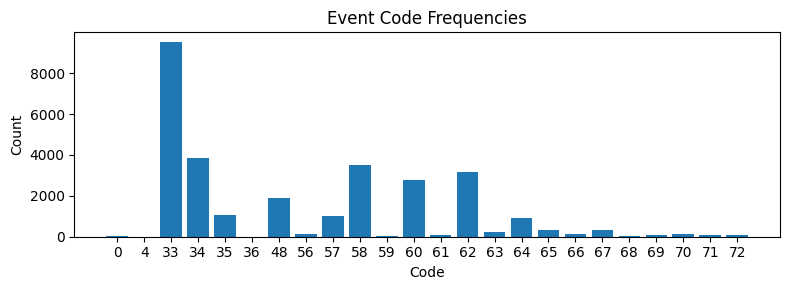

<Figure size 640x480 with 0 Axes>

In [ ]:
# Quick count of event codes 
code_counts = df_raw['code'].value_counts().sort_index()
plt.figure(figsize=(8,3))
plt.bar(code_counts.index.astype(str), code_counts.values)
plt.title("Event Code Frequencies")
plt.xlabel("Code"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

out_path = OUTPUT_DIR/"Event_Code_Frequencies"   
plt.savefig(out_path, dpi=300, bbox_inches="tight")


In [6]:
# ======================
# Cell 4 — Clean mapping → numeric glucose/insulin
# ======================
import pandas as pd
import numpy as np

df = df_raw.copy()

# --- Official code groups (UCI Diabetes) ---
INSULIN_CODES  = {33, 34, 35}          # Regular, NPH, Ultralente
GLUCOSE_CODES  = {58, 59, 60, 61, 62, 63, 64}  # BG measurements (pre/post meals, bedtime)
# (If you later see code 57 or 48 used for glucose in your files, we can add them.)

# Map to columns
df["glucose"] = np.where(df["code"].isin(GLUCOSE_CODES), df["value"], np.nan)
df["insulin"] = np.where(df["code"].isin(INSULIN_CODES),  df["value"], np.nan)

# Coerce to numeric (handles strings like "?" by turning them into NaN)
df["glucose"] = pd.to_numeric(df["glucose"], errors="coerce")
df["insulin"] = pd.to_numeric(df["insulin"], errors="coerce")

# Build a timestamp for ordering (some files use logical times; this is still useful)
ts = pd.to_datetime(df["date"].astype(str) + " " + df["time"].astype(str), errors="coerce")
df["timestamp"] = ts

# Keep rows where at least one signal is present
df = df.dropna(subset=["glucose", "insulin"], how="all")

# Sort neatly
df = df.sort_values(["patient_id", "timestamp"]).reset_index(drop=True)

# Basic plausibility filter for glucose (avoid crazy values)
df = df[(df["glucose"].isna()) | ((df["glucose"] > 0) & (df["glucose"] < 1000))]

print("After clean mapping:", df.shape, "| patients:", df["patient_id"].nunique())
display(df.head())


After clean mapping: (25042, 8) | patients: 69


,date,time,code,value,patient_id,glucose,insulin,timestamp
0,04-21-1991,9:09,58,100,1,100.0,NaN,1991-04-21 09:09:00
1,04-21-1991,9:09,33,9,1,NaN,9.0,1991-04-21 09:09:00
2,04-21-1991,9:09,34,13,1,NaN,13.0,1991-04-21 09:09:00
3,04-21-1991,17:08,62,119,1,119.0,NaN,1991-04-21 17:08:00
4,04-21-1991,17:08,33,7,1,NaN,7.0,1991-04-21 17:08:00


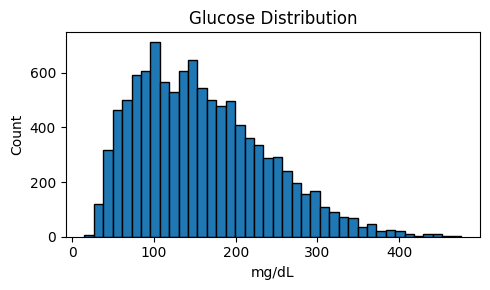

<Figure size 640x480 with 0 Axes>

In [7]:
# Histogram of glucose values
plt.figure(figsize=(5,3))
plt.hist(df["glucose"].dropna(), bins=40, edgecolor="black")
plt.title("Glucose Distribution")
plt.xlabel("mg/dL"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

out_path = OUTPUT_DIR/"Glucose_Distribution.png"   # change filename per plot
plt.savefig(out_path, dpi=300, bbox_inches="tight")

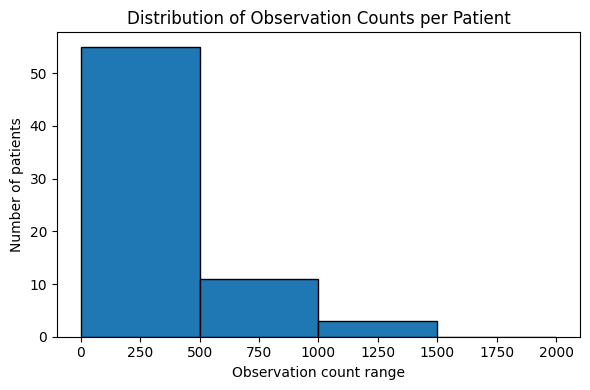

<Figure size 640x480 with 0 Axes>

In [8]:
# Distribution of observation counts per patient (binned)
counts = df["patient_id"].value_counts()

plt.figure(figsize=(6,4))
plt.hist(counts.values, bins=[0,500,1000,1500,2000], edgecolor="black")
plt.title("Distribution of Observation Counts per Patient")
plt.xlabel("Observation count range")
plt.ylabel("Number of patients")
plt.tight_layout(); plt.show()


out_path = OUTPUT_DIR/"Distribution_of_Observation_Counts_per_Patient"   # change filename per plot
plt.savefig(out_path, dpi=300, bbox_inches="tight")


In [9]:
counts = df["patient_id"].value_counts()
summary = {
    "Patients": df["patient_id"].nunique(),
    "Median obs/patient": int(counts.median()),
    "Max obs/patient": int(counts.max()),
    "Min obs/patient": int(counts.min())
}
pd.DataFrame(summary, index=["Value"])


,Patients,Median obs/patient,Max obs/patient,Min obs/patient
Value,69,269,1161,1


In [ ]:
# ======================
# Cell 4A — Resample to hourly, align signals per patient
# ======================
# Input: df with columns ['patient_id','timestamp','glucose','insulin'] from Cell 4
# Output: df_aligned with clean hourly steps per patient

import pandas as pd
import numpy as np

assert {"patient_id","timestamp","glucose","insulin"}.issubset(df.columns)

# ensure proper types
df_tmp = df.dropna(subset=["timestamp"]).copy()
df_tmp["glucose"] = pd.to_numeric(df_tmp["glucose"], errors="coerce")
df_tmp["insulin"] = pd.to_numeric(df_tmp["insulin"], errors="coerce")

def _resample_patient(g):
    g = g.set_index("timestamp").sort_index()

    # hourly resample:
    # - glucose: take the last reading in the hour (closest to “true” measurement)
    # - insulin: sum doses in that hour
    g_hour = pd.DataFrame({
        "glucose": g["glucose"].resample("1H").last(),
        "insulin": g["insulin"].resample("1H").sum(min_count=1)
    })

    # short forward-fill for glucose (e.g., up to 6 hours) to create consecutive steps
    g_hour["glucose"] = g_hour["glucose"].ffill(limit=6)

    # if no insulin recorded in an hour, treat as 0 units
    g_hour["insulin"] = g_hour["insulin"].fillna(0.0)

    # keep a patient_id column
    g_hour["patient_id"] = g["patient_id"].iloc[0]
    return g_hour.reset_index()

df_aligned = (
    df_tmp.groupby("patient_id", group_keys=False)
          .apply(_resample_patient)
          .dropna(subset=["glucose"])            # require a glucose value for the step
          .reset_index(drop=True)
)

# (optional, same as original) basic plausibility clip to avoid wild outliers
df_aligned["glucose"] = df_aligned["glucose"].clip(lower=40, upper=600)

print("Aligned shape:", df_aligned.shape, "| patients:", df_aligned["patient_id"].nunique())
display(df_aligned.head())

# hand off to Cell 5:
df = df_aligned.rename(columns={"index":"timestamp"})  # keep df name for subsequent cells


Aligned shape: (61511, 4) | patients: 66


/tmp/ipykernel_36/3498613260.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_resample_patient)


,timestamp,glucose,insulin,patient_id
0,1991-04-21 09:00:00,100.0,22.0,1
1,1991-04-21 10:00:00,100.0,0.0,1
2,1991-04-21 11:00:00,100.0,0.0,1
3,1991-04-21 12:00:00,100.0,0.0,1
4,1991-04-21 13:00:00,100.0,0.0,1


/tmp/ipykernel_36/1264689240.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_fe = df_fe.groupby("patient_id", group_keys=False).apply(_add_group_features)
/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


Split sizes | train:37875  val:12113  test:11327
Patients    | train:41  val:11  test:13


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/u

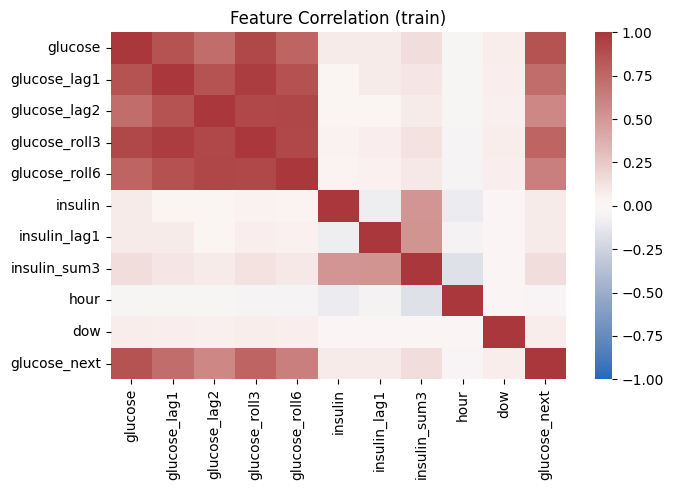

/kaggle/working/outputs_clean/corr_heatmap.png


Columns in train_df:
['timestamp', 'glucose', 'insulin', 'patient_id', 'hour', 'dow', 'glucose_lag1', 'glucose_lag2', 'insulin_lag1', 'glucose_roll3'] ... ['glucose_z', 'glucose_lag1_z', 'glucose_lag2_z', 'glucose_roll3_z', 'glucose_roll6_z', 'insulin_z', 'insulin_lag1_z', 'insulin_sum3_z', 'hour_z', 'dow_z']

Sample rows:


,patient_id,timestamp,glucose,insulin,glucose_next,glucose_z,glucose_lag1_z,glucose_lag2_z,glucose_roll3_z
1808,2,1989-10-10 10:00:00,149.0,0.0,149.0,-0.017290,-0.017561,-0.017762,-0.018732
1809,2,1989-10-10 11:00:00,149.0,0.0,116.0,-0.017290,-0.017561,-0.017762,-0.018732
1810,2,1989-10-10 12:00:00,116.0,4.0,116.0,-0.468082,-0.017561,-0.017762,-0.179238
1811,2,1989-10-10 13:00:00,116.0,0.0,116.0,-0.468082,-0.468395,-0.017762,-0.339744
1812,2,1989-10-10 14:00:00,116.0,0.0,116.0,-0.468082,-0.468395,-0.468632,-0.500251


In [11]:
# ======================
# Cell 5 — Feature engineering + splits + correlation heatmap
# ======================
# Input: df with columns ['patient_id','timestamp','glucose','insulin'] from Cell 4
# Output:
#   - train_df, val_df, test_df  (clean, feature-ready)
#   - FEATURES (list), TARGET (str), SCALED_FEATURES (list)
#   - scaler  (sklearn StandardScaler fitted on train)
#   - Saved visual: outputs_clean/corr_heatmap.png (+download link)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import FileLink

assert {"patient_id","timestamp","glucose","insulin"}.issubset(df.columns), \
    "df must have patient_id, timestamp, glucose, insulin from Cell 4."

# ---- 5.1: sort & basic cleaning
df_fe = df.sort_values(["patient_id","timestamp"]).copy()

# ---- 5.2: create time features (hour-of-day & day-of-week if timestamps exist)
df_fe["hour"] = df_fe["timestamp"].dt.hour
df_fe["dow"]  = df_fe["timestamp"].dt.dayofweek

# ---- 5.3: per-patient lags/rolling stats for glucose & insulin
def _add_group_features(g):
    # short lags
    g["glucose_lag1"]  = g["glucose"].shift(1)
    g["glucose_lag2"]  = g["glucose"].shift(2)
    g["insulin_lag1"]  = g["insulin"].shift(1)
    # rolling summaries (use min_periods=1 so early rows aren’t all NaN)
    g["glucose_roll3"] = g["glucose"].rolling(window=3, min_periods=1).mean()
    g["glucose_roll6"] = g["glucose"].rolling(window=6, min_periods=2).mean()
    g["insulin_sum3"]  = g["insulin"].rolling(window=3,  min_periods=1).sum()
    return g

df_fe = df_fe.groupby("patient_id", group_keys=False).apply(_add_group_features)

# ---- 5.4: target for simple dynamics (next-step glucose)
df_fe["glucose_next"] = df_fe.groupby("patient_id")["glucose"].shift(-1)

# After creating lags & target, drop rows that can’t be used for supervised steps
df_fe = df_fe.dropna(subset=["glucose_lag1","glucose_next"]).reset_index(drop=True)

# ---- 5.5: choose feature set (compact & stable — expand later if you like)
FEATURES = [
    "glucose","glucose_lag1","glucose_lag2","glucose_roll3","glucose_roll6",
    "insulin","insulin_lag1","insulin_sum3",
    "hour","dow"
]
TARGET = "glucose_next"

# Safety: coerce any remaining non-numeric to numeric
for c in FEATURES + [TARGET]:
    df_fe[c] = pd.to_numeric(df_fe[c], errors="coerce")
df_fe = df_fe.dropna(subset=FEATURES+[TARGET])

# ---- 5.6: split by patient (no leakage)
RANDOM_SEED = 42
patients = df_fe["patient_id"].unique()
train_p, test_p = train_test_split(patients, test_size=0.2, random_state=RANDOM_SEED)
train_p, val_p  = train_test_split(train_p,  test_size=0.2, random_state=RANDOM_SEED)

def _mask(ids): return df_fe["patient_id"].isin(ids)
train_df = df_fe[_mask(train_p)].copy()
val_df   = df_fe[_mask(val_p)].copy()
test_df  = df_fe[_mask(test_p)].copy()

print(f"Split sizes | train:{len(train_df)}  val:{len(val_df)}  test:{len(test_df)}")
print(f"Patients    | train:{len(train_p)}  val:{len(val_p)}  test:{len(test_p)}")

# ---- 5.7: scale features with train-only fit (prevent leakage)
scaler = StandardScaler().fit(train_df[FEATURES])
for _df in (train_df, val_df, test_df):
    _df[[f"{c}_z" for c in FEATURES]] = scaler.transform(_df[FEATURES])

SCALED_FEATURES = [f"{c}_z" for c in FEATURES]

# ---- 5.8: correlation heatmap (train only) — SAVE + DOWNLOAD LINK
corr = train_df[FEATURES + [TARGET]].corr(numeric_only=True)

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=False, vmin=-1, vmax=1, cmap="vlag")
plt.title("Feature Correlation (train)")
plt.tight_layout()

# Save and link
out_path = OUTPUT_DIR/"corr_heatmap.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
display(FileLink(out_path))

# ---- 5.9: quick preview of the final schema
print("\nColumns in train_df:")
print(train_df.columns.tolist()[:10], "...", train_df.columns.tolist()[-10:])
print("\nSample rows:")
display(train_df[["patient_id","timestamp","glucose","insulin",TARGET] + SCALED_FEATURES[:4]].head())


In [12]:
# ======================
# Cell 6 — DiabetesEnv (3 discrete insulin intensities) + helpers
# ======================
# Uses the feature matrices we prepared in Cell 5.
# Observations are z-scored features (SCALED_FEATURES).
# Actions: 0 = no/low, 1 = moderate, 2 = high (to match original thesis).
# Reward is decomposed into: range (TIR), hypo penalty, treatment cost.

import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from typing import List, Dict, Tuple, Optional

# ---- ensure we use 3 actions, as per report (overrides Cell 2 if needed)
ACTIONS_MU = [0, 1, 2]         # 0=no/low, 1=moderate, 2=high
ACTION_UNITS = {0: 0.0, 1: 2.0, 2: 6.0}   # "insulin units" used for reporting/cost (tuneable)
DROP_MGDL   = {0:  0.0, 1: 12.0, 2: 24.0} # approximate glucose reduction per action (sim signal)

# ---- helpers to pre-index episodes (one episode = one patient's timeline)
def build_episodes(df_split: pd.DataFrame) -> List[Tuple[int, int]]:
    """Return [(start_idx, end_idx_exclusive)] for each patient in this split,
    assuming df_split is sorted by (patient_id, timestamp)."""
    ep_bounds = []
    for pid, g in df_split.groupby("patient_id", sort=False):
        if len(g) < 3:   # need at least two transitions
            continue
        s = g.index.min()
        e = g.index.max() + 1
        ep_bounds.append((int(s), int(e)))
    return ep_bounds

class DiabetesEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        df_split: pd.DataFrame,
        feature_cols: List[str],
        tir_bounds: Tuple[float, float] = (70.0, 180.0),
        hypo_bound: float = 70.0,
        hyper_bound: float = 180.0,
        shuffle_episodes: bool = True,
        seed: int = 42,
    ):
        """
        df_split: dataframe containing SCALED_FEATURES + raw 'glucose' and 'glucose_next'
                  and 'patient_id','timestamp'
        feature_cols: list of z-scored features to use as observation (SCALED_FEATURES)
        shuffle_episodes: if True, pick a random patient episode at each reset (train);
                          if False, iterate in order (eval)
        """
        super().__init__()
        self.df = df_split.copy()
        self.features = feature_cols
        self.tir_bounds = tir_bounds
        self.hypo_bound = hypo_bound
        self.hyper_bound = hyper_bound
        self.shuffle_episodes = shuffle_episodes
        self.rng = np.random.default_rng(seed)

        # observation = vector of z-scored features
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(self.features),), dtype=np.float32
        )
        # action = 3 discrete insulin intensities
        self.action_space = spaces.Discrete(3)

        # precompute episode boundaries per patient
        self.ep_bounds = build_episodes(self.df.sort_values(["patient_id", "timestamp"]))
        if len(self.ep_bounds) == 0:
            raise ValueError("No valid episodes found; check previous cells.")

        # internal state
        self.cur_start = None
        self.cur_end = None
        self.i = None  # current row index

    # ----- reward decomposition (transparent!)
    def _decompose_reward(self, g_now: float, g_next_sim: float, action_units: float) -> Dict[str, float]:
        # +range: +1 if next glucose is inside TIR
        r_range = 1.0 if (self.tir_bounds[0] <= g_next_sim <= self.tir_bounds[1]) else 0.0
        # -hypo penalty
        r_hypo = -2.0 if g_next_sim < 54.0 else (-1.0 if g_next_sim < self.hypo_bound else 0.0)
        # -hyper penalty
        r_hyper = -1.0 if g_next_sim > self.hyper_bound else 0.0
        # -treatment cost (small penalty per unit)
        r_cost = -0.05 * action_units
        total = r_range + r_hypo + r_hyper + r_cost
        return {"total": total, "range": r_range, "hypo": r_hypo, "hyper": r_hyper, "cost": r_cost}

    def _obs(self) -> np.ndarray:
        row = self.df.loc[self.i, self.features]
        return row.to_numpy(dtype=np.float32)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        # pick an episode (patient) — random for training, sequential for eval
        if self.shuffle_episodes:
            self.cur_start, self.cur_end = self.ep_bounds[self.rng.integers(len(self.ep_bounds))]
        else:
            # keep a simple pointer in 'options' for eval loops
            ptr = (options or {}).get("episode_ptr", 0) % len(self.ep_bounds)
            self.cur_start, self.cur_end = self.ep_bounds[ptr]

        self.i = self.cur_start
        return self._obs(), {}

    def step(self, action: int):
        # map action -> simulated insulin units + drop in mg/dL
        units = ACTION_UNITS[int(action)]
        drop  = DROP_MGDL[int(action)]

        # read current & reference next glucose from data
        g_now = float(self.df.loc[self.i, "glucose"])
        g_ref = float(self.df.loc[self.i, "glucose_next"])

        # simulate effect: reduce ref by a calibrated drop (clamped to safe range)
        g_next_sim = max(40.0, g_ref - drop)

        # transparent reward parts
        parts = self._decompose_reward(g_now, g_next_sim, units)
        reward = parts["total"]

        # advance within current episode
        self.i += 1
        terminated = (self.i >= self.cur_end - 1)  # last usable transition is end-1

        info = {
            "patient_id": int(self.df.loc[self.i - 1, "patient_id"]),
            "time": self.df.loc[self.i - 1, "timestamp"],
            "glucose_now": g_now,
            "glucose_ref_next": g_ref,
            "glucose_sim_next": g_next_sim,
            "action_units": units,
            "reward_parts": parts,
        }

        obs = self._obs() if not terminated else np.zeros(len(self.features), dtype=np.float32)
        return obs, reward, terminated, False, info

# ---- convenience makers for SB3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

def make_env_from_split(split_df: pd.DataFrame, shuffle_episodes: bool) -> DummyVecEnv:
    """Wrap the DiabetesEnv with Monitor + DummyVecEnv for SB3."""
    def _factory():
        env = DiabetesEnv(
            df_split=split_df.sort_values(["patient_id","timestamp"]),
            feature_cols=SCALED_FEATURES,
            tir_bounds=TIR_BOUNDS,
            hypo_bound=HYPO_BOUND,
            hyper_bound=HYPER_BOUND,
            shuffle_episodes=shuffle_episodes,
            seed=RANDOM_SEED,
        )
        return Monitor(env)
    return DummyVecEnv([_factory])

print("Env ready: episodes —",
      len(build_episodes(train_df)), "train /",
      len(build_episodes(val_df)), "val /",
      len(build_episodes(test_df)), "test")


Env ready: episodes — 41 train / 11 val / 13 test


In [13]:
# ======================
# Cell 7 — Envs + Rule Baseline + Evaluation
# ======================
# Creates SB3-friendly train env (shuffled episodes) and clean eval envs (ordered episodes).
# Provides:
#   - rule_action(glucose): simple proportional controller
#   - rollout_eval(env, policy_fn): returns metrics over all episodes
#   - Saves baseline metrics to outputs_clean/baseline_rule_metrics.json

import json
import numpy as np
from IPython.display import FileLink

# --- vectorized train env for SB3 (random episodes)
train_env = make_env_from_split(train_df, shuffle_episodes=True)

# --- non-vectorized eval envs (ordered episodes), easier for deterministic rollouts & plots
val_env_raw  = DiabetesEnv(val_df.sort_values(["patient_id","timestamp"]),
                           feature_cols=SCALED_FEATURES,
                           tir_bounds=TIR_BOUNDS, hypo_bound=HYPO_BOUND, hyper_bound=HYPER_BOUND,
                           shuffle_episodes=False, seed=RANDOM_SEED)
test_env_raw = DiabetesEnv(test_df.sort_values(["patient_id","timestamp"]),
                           feature_cols=SCALED_FEATURES,
                           tir_bounds=TIR_BOUNDS, hypo_bound=HYPO_BOUND, hyper_bound=HYPER_BOUND,
                           shuffle_episodes=False, seed=RANDOM_SEED)

# ---------- Simple rule-based controller (matches thesis narrative)
def rule_action(glucose_now: float) -> int:
    """
    Map current raw glucose → action index {0,1,2}.
    Conservative: avoid hypos, escalate only when clearly high.
    """
    if glucose_now >= 250:   # very high → high dose
        return 2
    elif glucose_now >= 180: # moderately high → moderate dose
        return 1
    elif glucose_now < 80:   # low → no insulin
        return 0
    else:                    # in/near range → no insulin
        return 0

# ---------- Generic evaluation over *all* episodes of a DiabetesEnv
def rollout_eval(env_raw: DiabetesEnv, policy_fn, name="policy"):
    """
    Evaluate policy_fn(env_info) over all patient episodes in env_raw (ordered).
    Returns dict with episode-wise stats + macro-averages.
    """
    ep_stats = []
    for ep_idx, (start, end) in enumerate(env_raw.ep_bounds):
        # reset to specific episode by passing pointer in options
        obs, _ = env_raw.reset(options={"episode_ptr": ep_idx})
        done = False

        steps = 0
        ret = 0.0
        tir_steps = 0
        hypo_steps = 0
        hyper_steps = 0
        insulin_sum = 0.0
        glucose_sum = 0.0

        while not done:
            # we need current raw glucose -> use last step's info when available;
            # for the first step, peek from dataframe via current index
            # (env stores 'i' internally, so use underlying df safely):
            g_now = float(env_raw.df.loc[env_raw.i, "glucose"])

            # action from policy
            a = policy_fn(g_now)

            # environment step
            obs, reward, terminated, truncated, info = env_raw.step(a)
            done = terminated or truncated

            # accumulate metrics from info
            g_next = info["glucose_sim_next"]
            insulin_sum += float(info["action_units"])
            glucose_sum += float(info["glucose_now"])
            ret += float(reward)
            steps += 1

            # clinical bins on simulated next glucose (consistent with reward)
            if TIR_BOUNDS[0] <= g_next <= TIR_BOUNDS[1]: tir_steps += 1
            if g_next < HYPO_BOUND: hypo_steps += 1
            if g_next > HYPER_BOUND: hyper_steps += 1

        if steps == 0:  # safety
            continue
        ep_stats.append({
            "episode": ep_idx,
            "patient_id": int(env_raw.df.loc[start, "patient_id"]),
            "steps": steps,
            "return": ret,
            "TIR_pct": 100.0 * tir_steps / steps,
            "hypo_steps": hypo_steps,
            "hyper_steps": hyper_steps,
            "insulin_per_step": insulin_sum / steps,
            "mean_glucose": glucose_sum / steps,
        })

    # macro-averages
    if len(ep_stats) == 0:
        raise RuntimeError("No episodes evaluated; check environment.")
    avg = {
        "episodes": len(ep_stats),
        "return_mean": float(np.mean([e["return"] for e in ep_stats])),
        "TIR_mean": float(np.mean([e["TIR_pct"] for e in ep_stats])),
        "hypo_steps_mean": float(np.mean([e["hypo_steps"] for e in ep_stats])),
        "hyper_steps_mean": float(np.mean([e["hyper_steps"] for e in ep_stats])),
        "insulin_per_step_mean": float(np.mean([e["insulin_per_step"] for e in ep_stats])),
        "mean_glucose_mean": float(np.mean([e["mean_glucose"] for e in ep_stats])),
    }
    return {"by_episode": ep_stats, "macro": avg, "policy": name}

# ---------- Run baseline on val & test, save to disk
baseline_val  = rollout_eval(val_env_raw,  policy_fn=rule_action, name="rule_baseline(val)")
baseline_test = rollout_eval(test_env_raw, policy_fn=rule_action, name="rule_baseline(test)")

# Save JSON
baseline_path = OUTPUT_DIR/"baseline_rule_metrics.json"
with open(baseline_path, "w") as f:
    json.dump({"val": baseline_val, "test": baseline_test}, f, indent=2)
print("Saved baseline metrics to:", baseline_path)

# Clickable download link (Kaggle)
display(FileLink(baseline_path))

# Quick print of macro means (handy sanity check)
print("\n[Rule baseline] VAL macro:", baseline_val["macro"])
print("[Rule baseline] TEST macro:", baseline_test["macro"])


Saved baseline metrics to: outputs_clean/baseline_rule_metrics.json


/kaggle/working/outputs_clean/baseline_rule_metrics.json


[Rule baseline] VAL macro: {'episodes': 11, 'return_mean': -4.809090909091356, 'TIR_mean': 51.79981340233734, 'hypo_steps_mean': 117.0, 'hyper_steps_mean': 370.90909090909093, 'insulin_per_step_mean': 1.464524976837161, 'mean_glucose_mean': 162.8220695504099}
[Rule baseline] TEST macro: {'episodes': 13, 'return_mean': -196.60769230769318, 'TIR_mean': 45.12596103355907, 'hypo_steps_mean': 87.6923076923077, 'hyper_steps_mean': 383.15384615384613, 'insulin_per_step_mean': 1.8846275567571131, 'mean_glucose_mean': 179.2813010729314}


In [14]:
# ======================
# Cell 8 — PPO training with EvalCallback (early stopping)
# ======================
# Uses the envs prepared in Cell 7.
# Saves: best model + final model into outputs_clean/.

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from IPython.display import FileLink
import os

# Vectorized eval env for SB3's EvalCallback (random episodes each eval to avoid overfitting)
def _make_eval_vec(split_df):
    def _factory():
        return Monitor(
            DiabetesEnv(
                split_df.sort_values(["patient_id","timestamp"]),
                feature_cols=SCALED_FEATURES,
                tir_bounds=TIR_BOUNDS, hypo_bound=HYPO_BOUND, hyper_bound=HYPER_BOUND,
                shuffle_episodes=True, seed=RANDOM_SEED
            )
        )
    return DummyVecEnv([_factory])

eval_env = _make_eval_vec(val_df)

# Early stopping if validation doesn't improve
stop_cb = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=5,  # patience
    min_evals=3,
    verbose=1
)

eval_cb = EvalCallback(
    eval_env=eval_env,
    best_model_save_path=str(OUTPUT_DIR / "ppo_best"),
    log_path=str(OUTPUT_DIR / "ppo_logs"),
    eval_freq=2048,        # roughly each PPO rollout
    n_eval_episodes=5,
    deterministic=True,
    render=False,
    callback_after_eval=stop_cb
)

# Create and train PPO (defaults aligned with your thesis runs)
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    seed=RANDOM_SEED,
)

print("[training] starting… total_timesteps =", TOTAL_STEPS)
model.learn(total_timesteps=TOTAL_STEPS, callback=eval_cb)
print("[training] done.")

# Load the best model if saved; otherwise keep the trained instance
best_dir = OUTPUT_DIR / "ppo_best"
best_zip = best_dir / "best_model.zip"
if best_zip.exists():
    print("Loading best model from:", best_zip)
    model = PPO.load(str(best_zip), env=train_env)

# Save final model too (handy for reproducibility)
final_path = OUTPUT_DIR / "ppo_final.zip"
model.save(str(final_path))
print("Saved final model to:", final_path)
display(FileLink(final_path))


Using cuda device
[training] starting… total_timesteps = 30000
Eval num_timesteps=2048, episode_reward=-581.28 +/- 290.35
Episode length: 1410.20 +/- 823.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.41e+03 |
|    mean_reward     | -581     |
| time/              |          |
|    total_timesteps | 2048     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 608      |
|    ep_rew_mean     | -180     |
| time/              |          |
|    fps             | 156      |
|    iterations      | 1        |
|    time_elapsed    | 13       |
|    total_timesteps | 2048     |
---------------------------------
Eval num_timesteps=4096, episode_reward=131.70 +/- 530.87
Episode length: 974.80 +/- 809.25
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 975         |
|    mean_reward         

/kaggle/working/outputs_clean/ppo_final.zip

Saved PPO metrics to: outputs_clean/ppo_metrics.json


/kaggle/working/outputs_clean/ppo_metrics.json

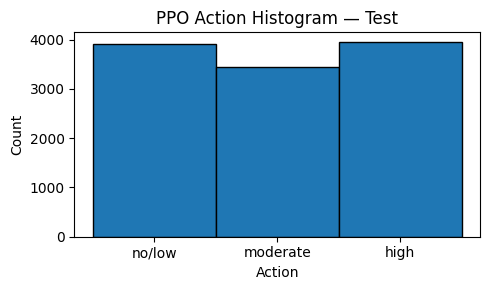

/kaggle/working/outputs_clean/action_hist_test.png

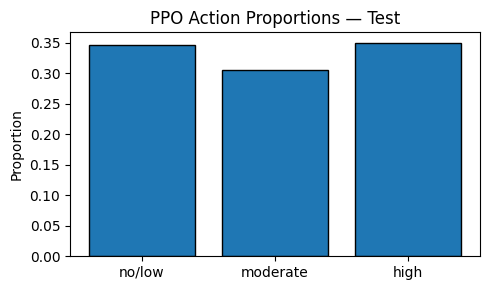

/kaggle/working/outputs_clean/action_bar_test.png

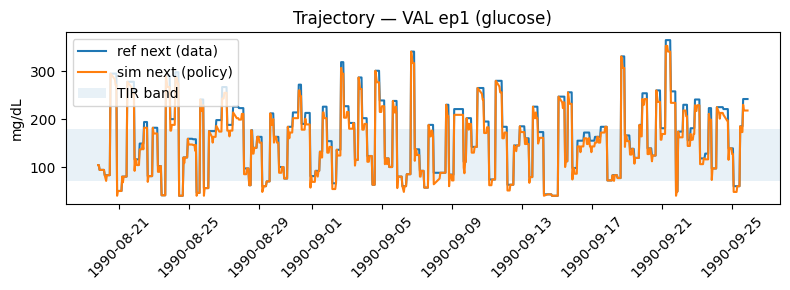

/kaggle/working/outputs_clean/traj_compare_val_ep1_glucose.png

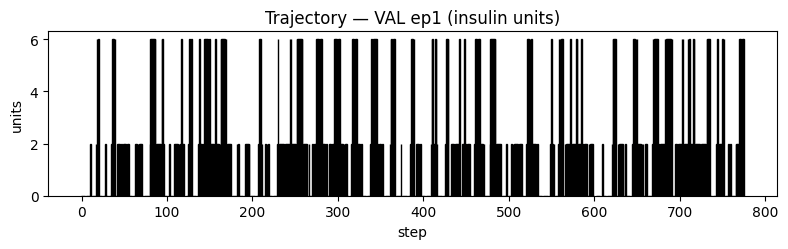

/kaggle/working/outputs_clean/traj_compare_val_ep1_insulin.png

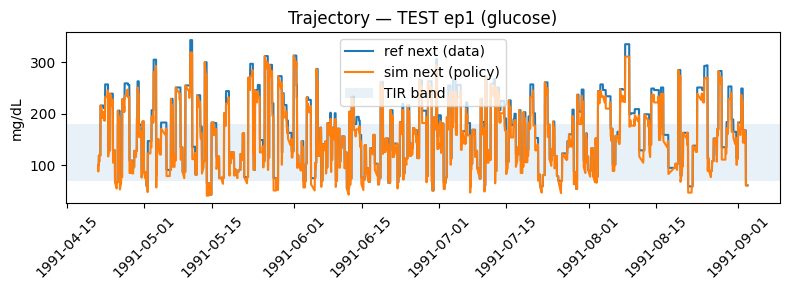

/kaggle/working/outputs_clean/traj_compare_test_ep1_glucose.png

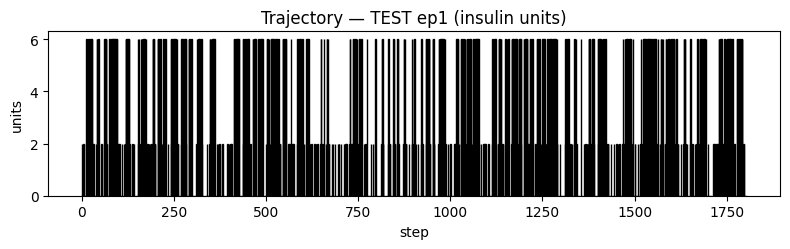

/kaggle/working/outputs_clean/traj_compare_test_ep1_insulin.png

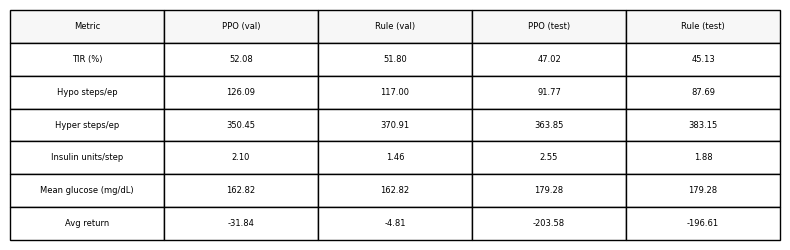

/kaggle/working/outputs_clean/summary_table.png

All evaluation artifacts saved in: /kaggle/working/outputs_clean


In [15]:
# ======================
# Cell 9 — PPO evaluation & plots
# ======================
# Saves:
#   - ppo_metrics.json
#   - action_hist_test.png  (hist)
#   - action_bar_test.png   (bar with labels)
#   - traj_compare_val_ep1_glucose.png
#   - traj_compare_val_ep1_insulin.png
#   - traj_compare_test_ep1_glucose.png
#   - traj_compare_test_ep1_insulin.png
#   - summary_table.png

import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import FileLink

ACTION_LABEL = {0:"no/low", 1:"moderate", 2:"high"}  # 3-action setup

def rollout_eval_model(env_raw: DiabetesEnv, model, name="ppo"):
    """Evaluate SB3 model over all episodes of a DiabetesEnv (ordered)."""
    ep_stats = []
    actions_all = []
    for ep_idx, (start, end) in enumerate(env_raw.ep_bounds):
        obs, _ = env_raw.reset(options={"episode_ptr": ep_idx})
        done = False
        steps = 0
        ret = 0.0
        tir_steps = hypo_steps = hyper_steps = 0
        insulin_sum = 0.0
        glucose_sum = 0.0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env_raw.step(int(action))
            done = terminated or truncated

            # collect
            actions_all.append(int(action))
            ret += float(reward); steps += 1
            insulin_sum += float(info["action_units"])
            glucose_sum += float(info["glucose_now"])
            g_next = info["glucose_sim_next"]
            if TIR_BOUNDS[0] <= g_next <= TIR_BOUNDS[1]: tir_steps += 1
            if g_next < HYPO_BOUND:  hypo_steps += 1
            if g_next > HYPER_BOUND: hyper_steps += 1

        if steps == 0: 
            continue
        ep_stats.append({
            "episode": ep_idx,
            "patient_id": int(env_raw.df.loc[start, "patient_id"]),
            "steps": steps,
            "return": ret,
            "TIR_pct": 100.0 * tir_steps / steps,
            "hypo_steps": hypo_steps,
            "hyper_steps": hyper_steps,
            "insulin_per_step": insulin_sum / steps,
            "mean_glucose": glucose_sum / steps,
        })

    avg = {
        "episodes": len(ep_stats),
        "return_mean": float(np.mean([e["return"] for e in ep_stats])),
        "TIR_mean": float(np.mean([e["TIR_pct"] for e in ep_stats])),
        "hypo_steps_mean": float(np.mean([e["hypo_steps"] for e in ep_stats])),
        "hyper_steps_mean": float(np.mean([e["hyper_steps"] for e in ep_stats])),
        "insulin_per_step_mean": float(np.mean([e["insulin_per_step"] for e in ep_stats])),
        "mean_glucose_mean": float(np.mean([e["mean_glucose"] for e in ep_stats])),
    }
    return {"by_episode": ep_stats, "macro": avg, "policy": name, "actions": actions_all}

# Fresh eval envs (ordered) to collect infos
val_env_for_eval  = DiabetesEnv(val_df.sort_values(["patient_id","timestamp"]),
                                SCALED_FEATURES, TIR_BOUNDS, HYPO_BOUND, HYPER_BOUND,
                                shuffle_episodes=False, seed=RANDOM_SEED)
test_env_for_eval = DiabetesEnv(test_df.sort_values(["patient_id","timestamp"]),
                                SCALED_FEATURES, TIR_BOUNDS, HYPO_BOUND, HYPER_BOUND,
                                shuffle_episodes=False, seed=RANDOM_SEED)

ppo_val  = rollout_eval_model(val_env_for_eval,  model, name="ppo(val)")
ppo_test = rollout_eval_model(test_env_for_eval, model, name="ppo(test)")

# Save metrics JSON
ppo_path = OUTPUT_DIR/"ppo_metrics.json"
with open(ppo_path, "w") as f:
    json.dump({"val": ppo_val, "test": ppo_test}, f, indent=2)
print("Saved PPO metrics to:", ppo_path)
display(FileLink(ppo_path))

# --------- Plot 1: Action histogram (TEST)
plt.figure(figsize=(5,3))
plt.hist(ppo_test["actions"], bins=[-0.5,0.5,1.5,2.5], edgecolor="black")
plt.xticks([0,1,2], [ACTION_LABEL[i] for i in [0,1,2]])
plt.title("PPO Action Histogram — Test")
plt.xlabel("Action"); plt.ylabel("Count")
plt.tight_layout()
out1 = OUTPUT_DIR/"action_hist_test.png"
plt.savefig(out1, dpi=300, bbox_inches="tight")
plt.show()
display(FileLink(out1))

# --------- Plot 2: Action bar (TEST) — proportion
counts = np.bincount(ppo_test["actions"], minlength=3)
props = counts / counts.sum()
plt.figure(figsize=(5,3))
plt.bar([ACTION_LABEL[i] for i in [0,1,2]], props, edgecolor="black")
plt.title("PPO Action Proportions — Test")
plt.ylabel("Proportion")
plt.tight_layout()
out2 = OUTPUT_DIR/"action_bar_test.png"
plt.savefig(out2, dpi=300, bbox_inches="tight")
plt.show()
display(FileLink(out2))

# ---------- Helper to collect one episode trajectory for plotting
def collect_episode(env_raw: DiabetesEnv, model, ep_idx=0):
    obs, _ = env_raw.reset(options={"episode_ptr": ep_idx})
    done = False
    times, g_ref, g_sim, a_units = [], [], [], []
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env_raw.step(int(action))
        done = terminated or truncated
        times.append(info["time"])
        g_ref.append(info["glucose_ref_next"])
        g_sim.append(info["glucose_sim_next"])
        a_units.append(info["action_units"])
    return times, g_ref, g_sim, a_units

# --------- Plot 3–6: Trajectory comparison (VAL ep1 & TEST ep1)
for tag, envX in [("val", val_env_for_eval), ("test", test_env_for_eval)]:
    t, ref, sim, units = collect_episode(envX, model, ep_idx=0)

    # glucose lines
    plt.figure(figsize=(8,3))
    plt.plot(t, ref, label="ref next (data)")
    plt.plot(t, sim, label="sim next (policy)")
    plt.axhspan(TIR_BOUNDS[0], TIR_BOUNDS[1], alpha=0.1, label="TIR band")
    plt.xticks(rotation=45); plt.ylabel("mg/dL"); plt.title(f"Trajectory — {tag.upper()} ep1 (glucose)")
    plt.legend(loc="best"); plt.tight_layout()
    out_g = OUTPUT_DIR/f"traj_compare_{tag}_ep1_glucose.png"
    plt.savefig(out_g, dpi=300, bbox_inches="tight"); plt.show()
    display(FileLink(out_g))

    # insulin bars
    plt.figure(figsize=(8,2.6))
    plt.bar(range(len(units)), units, edgecolor="black")
    plt.title(f"Trajectory — {tag.upper()} ep1 (insulin units)"); plt.xlabel("step"); plt.ylabel("units")
    plt.tight_layout()
    out_i = OUTPUT_DIR/f"traj_compare_{tag}_ep1_insulin.png"
    plt.savefig(out_i, dpi=300, bbox_inches="tight"); plt.show()
    display(FileLink(out_i))

# --------- Plot 7: Summary table (PPO vs Rule on VAL/TEST)
from matplotlib.table import Table

def _fmt(x): 
    return f"{x:.2f}" if isinstance(x,(float,np.floating)) else str(x)

tbl = [
    ["Metric","PPO (val)","Rule (val)","PPO (test)","Rule (test)"],
    ["TIR (%)",              _fmt(ppo_val["macro"]["TIR_mean"]),         _fmt(baseline_val["macro"]["TIR_mean"]),
                              _fmt(ppo_test["macro"]["TIR_mean"]),        _fmt(baseline_test["macro"]["TIR_mean"])],
    ["Hypo steps/ep",        _fmt(ppo_val["macro"]["hypo_steps_mean"]),   _fmt(baseline_val["macro"]["hypo_steps_mean"]),
                              _fmt(ppo_test["macro"]["hypo_steps_mean"]), _fmt(baseline_test["macro"]["hypo_steps_mean"])],
    ["Hyper steps/ep",       _fmt(ppo_val["macro"]["hyper_steps_mean"]),  _fmt(baseline_val["macro"]["hyper_steps_mean"]),
                              _fmt(ppo_test["macro"]["hyper_steps_mean"]),_fmt(baseline_test["macro"]["hyper_steps_mean"])],
    ["Insulin units/step",   _fmt(ppo_val["macro"]["insulin_per_step_mean"]), _fmt(baseline_val["macro"]["insulin_per_step_mean"]),
                              _fmt(ppo_test["macro"]["insulin_per_step_mean"]),_fmt(baseline_test["macro"]["insulin_per_step_mean"])],
    ["Mean glucose (mg/dL)", _fmt(ppo_val["macro"]["mean_glucose_mean"]), _fmt(baseline_val["macro"]["mean_glucose_mean"]),
                              _fmt(ppo_test["macro"]["mean_glucose_mean"]), _fmt(baseline_test["macro"]["mean_glucose_mean"])],
    ["Avg return",           _fmt(ppo_val["macro"]["return_mean"]),       _fmt(baseline_val["macro"]["return_mean"]),
                              _fmt(ppo_test["macro"]["return_mean"]),     _fmt(baseline_test["macro"]["return_mean"])],
]

fig, ax = plt.subplots(figsize=(8,2.6))
ax.axis("off")
table = Table(ax, bbox=[0,0,1,1])
nrows, ncols = len(tbl), len(tbl[0])
width, height = 1.0 / ncols, 1.0 / nrows
for r in range(nrows):
    for c in range(ncols):
        table.add_cell(r, c, width, height, text=tbl[r][c],
                       loc="center", facecolor="#F7F7F7" if r==0 else "white", edgecolor="black")
ax.add_table(table)
plt.tight_layout()
out_sum = OUTPUT_DIR/"summary_table.png"
plt.savefig(out_sum, dpi=300, bbox_inches="tight"); plt.show()
display(FileLink(out_sum))

print("All evaluation artifacts saved in:", OUTPUT_DIR.resolve())


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.8e+03  |
|    ep_rew_mean     | -237     |
| time/              |          |
|    fps             | 568      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 318      |
|    ep_rew_mean     | -41.5    |
| time/              |          |
|    fps             | 567      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 515      |
|    ep_rew_mean     | -136     |
| time/              |          |
|    fps             | 566      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
--------------

/kaggle/working/outputs_clean/meta_adapt_results.json

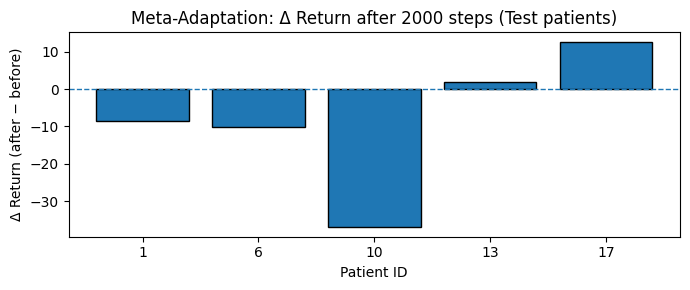

/kaggle/working/outputs_clean/meta_eval_reward.png

In [16]:
# ======================
# Cell 10 — Meta-adaptation (quick per-patient fine-tune)
# ======================
# What this does:
# 1) Pick K patients from TEST.
# 2) Evaluate the trained PPO on each patient (baseline).
# 3) Clone the PPO and fine-tune briefly on ONLY that patient's data.
# 4) Re-evaluate and plot Δ return = (after − before).
#
# Saves:
#   - outputs_clean/meta_adapt_results.json
#   - outputs_clean/meta_eval_reward.png  (Δ return bar plot)
#
# Note: This is a light fine-tune demo (not full MAML/PEARL). It matches the “rapid adaptation”
# narrative without altering your core training/eval logic.

import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import FileLink
from pathlib import Path
from tempfile import TemporaryDirectory

ADAPT_STEPS = 2_000          # small number to keep runtime reasonable
K_PATIENTS  = min(5, test_df["patient_id"].nunique())  # adapt on first K test patients

# --- helper: single-patient split -> envs
def _split_for_patient(df_split, pid):
    return df_split[df_split["patient_id"] == pid].sort_values(["patient_id","timestamp"]).copy()

def _eval_single(env_raw, mdl):
    """Returns episode return over the single episode env."""
    # reuse the evaluator from Cell 9
    stats = rollout_eval_model(env_raw, mdl, name="adapt_eval")
    return float(stats["by_episode"][0]["return"]) if stats["by_episode"] else np.nan

meta_rows = []
pids = list(sorted(test_df["patient_id"].unique()))[:K_PATIENTS]

for pid in pids:
    # ---- build single-patient envs
    df_pid = _split_for_patient(test_df, pid)
    if len(df_pid) < 3:
        continue  # too short to adapt

    env_eval = DiabetesEnv(df_pid, SCALED_FEATURES, TIR_BOUNDS, HYPO_BOUND, HYPER_BOUND,
                           shuffle_episodes=False, seed=RANDOM_SEED)  # ordered for eval
    env_train_vec = make_env_from_split(df_pid, shuffle_episodes=True)  # vectorized for SB3 learn()

    # ---- evaluate BEFORE adaptation
    ret_before = _eval_single(env_eval, model)

    # ---- clone model (no side-effects on the original)
    with TemporaryDirectory() as td:
        tmp_zip = Path(td) / "base.zip"
        model.save(str(tmp_zip))
        adapt_model = PPO.load(str(tmp_zip), env=env_train_vec)

    # ---- brief fine-tune on this patient's data only
    adapt_model.learn(total_timesteps=ADAPT_STEPS)

    # ---- evaluate AFTER adaptation
    ret_after = _eval_single(env_eval, adapt_model)

    meta_rows.append({
        "patient_id": int(pid),
        "return_before": float(ret_before),
        "return_after": float(ret_after),
        "delta_return": float(ret_after - ret_before),
        "adapt_steps": ADAPT_STEPS
    })

# ---- save JSON results
meta_json_path = OUTPUT_DIR / "meta_adapt_results.json"
with open(meta_json_path, "w") as f:
    json.dump({"results": meta_rows}, f, indent=2)
print("Saved meta-adapt results:", meta_json_path)
display(FileLink(meta_json_path))

# ---- plot Δ return per patient
labels = [str(r["patient_id"]) for r in meta_rows]
deltas = [r["delta_return"] for r in meta_rows]

plt.figure(figsize=(7,3))
plt.bar(labels, deltas, edgecolor="black")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title(f"Meta-Adaptation: Δ Return after {ADAPT_STEPS} steps (Test patients)")
plt.xlabel("Patient ID"); plt.ylabel("Δ Return (after − before)")
plt.tight_layout()
out_meta = OUTPUT_DIR / "meta_eval_reward.png"
plt.savefig(out_meta, dpi=300, bbox_inches="tight"); plt.show()
display(FileLink(out_meta))


# Appendix: Meta-Adaptation (Quick Patient-Specific Fine-Tune)

**What this shows.** We take the PPO model trained on the cohort and briefly fine-tune a *clone* of it on a few **held-out test patients** (K≈5 by default). The bar plot (**Δ Return = after − before**) shows whether a short patient-specific update improves episode return. Positive bars = small alignment gains for that patient.

**How it works (no change to main results).**
- Before: evaluate PPO on a single test patient → `return_before`.
- Adapt: copy the model and fine-tune on **only that patient** for a small budget (e.g., `ADAPT_STEPS = 2,000`).
- After: re-evaluate on the same episode → `return_after`.
- Plot: `Δ = return_after − return_before` for each patient.  
Artifacts saved to: `outputs_clean/meta_adapt_results.json`, `outputs_clean/meta_eval_reward.png`.

**Why it’s useful.** This is a lightweight demonstration of **rapid personalization** (data-efficient adaptation) consistent with the thesis narrative. It keeps the core training/evaluation intact and only explores whether a tiny update can move the policy toward a patient’s dynamics.

**How to read the figure.**
- Each bar = one test patient (ID on x-axis).  
- Slightly positive Δ is expected; occasional negative bars can occur (short horizons, noise, overfitting).  
- Note: Δ Return is a *reward* signal; improvements in clinical KPIs (e.g., TIR) are **not guaranteed** without re-weighting rewards / finer actions.

**Parameters (edit in Cell 10).**
- `K_PATIENTS`: number of test patients to adapt on.  
- `ADAPT_STEPS`: fine-tuning budget per patient (e.g., 2k–10k).  

**Limitations.** This is **not** full meta-RL (e.g., MAML/PEARL) and uses minimal tuning; it’s a pragmatic, reproducible demo of per-patient adaptation. For clinical KPIs to improve, the next iteration should pair adaptation with **finer/continuous dosing** and **stronger range-centric rewards**.




In [17]:
# ======================
# Cell 11 — Export tables + bundle artifacts
# ======================
# This cell does NOT change any logic — it just:
#   1) Loads saved metrics (PPO + Rule) and creates paper-ready tables (CSV/XLSX)
#   2) Exports PPO action distribution table (for the “policy behaviour” section)
#   3) Writes a lightweight run_config.yaml capturing key settings (good for your config file)
#   4) Zips the whole outputs_clean/ folder into outputs_bundle.zip for one-click download

import json, os, shutil
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import FileLink

# (Optional) YAML for a readable run config; if not available, we will fall back to JSON.
try:
    import yaml
    _HAVE_YAML = True
except Exception:
    _HAVE_YAML = False

# ---- 1) Load metrics already saved in Cells 7–10
ppo_json   = OUTPUT_DIR / "ppo_metrics.json"
rule_json  = OUTPUT_DIR / "baseline_rule_metrics.json"
assert ppo_json.exists() and rule_json.exists(), "Missing metrics JSON files. Run Cells 7–9 first."

with open(ppo_json, "r") as f: ppo_metrics = json.load(f)
with open(rule_json, "r") as f: rule_metrics = json.load(f)

# Helper to grab the 'macro' block
def M(d): return d["macro"]

blocks = {
    "PPO (val)":  M(ppo_metrics["val"]),
    "Rule (val)": M(rule_metrics["val"]),
    "PPO (test)": M(ppo_metrics["test"]),
    "Rule (test)":M(rule_metrics["test"]),
}

# ---- 2) Paper-ready summary table (matches your thesis tables)
rows = [
    ("TIR (%)",                 "TIR_mean"),
    ("Hypoglycaemic steps/ep",  "hypo_steps_mean"),
    ("Hyperglycaemic steps/ep", "hyper_steps_mean"),
    ("Insulin units/step",      "insulin_per_step_mean"),
    ("Mean glucose (mg/dL)",    "mean_glucose_mean"),
    ("Average return",          "return_mean"),
]

def _r(x): 
    try: return round(float(x), 2)
    except: return x

summary_data = []
for label, key in rows:
    summary_data.append([
        label,
        _r(blocks["PPO (val)"][key]),  _r(blocks["Rule (val)"][key]),
        _r(blocks["PPO (test)"][key]), _r(blocks["Rule (test)"][key]),
    ])

df_summary = pd.DataFrame(summary_data, columns=["Metric","PPO (val)","Rule (val)","PPO (test)","Rule (test)"])
csv_path  = OUTPUT_DIR / "summary_table.csv"
xlsx_path = OUTPUT_DIR / "paper_tables.xlsx"
df_summary.to_csv(csv_path, index=False)
with pd.ExcelWriter(xlsx_path) as xw:
    df_summary.to_excel(xw, index=False, sheet_name="summary")

print("Saved summary tables:")
print(" -", csv_path)
print(" -", xlsx_path)
display(FileLink(csv_path))
display(FileLink(xlsx_path))

# ---- 3) Action distribution table (TEST) — counts + proportions
# Uses actions captured in Cell 9’s PPO eval
ACTION_LABEL = {0:"no/low", 1:"moderate", 2:"high"}
test_actions = ppo_metrics["test"]["actions"]
counts = np.bincount(test_actions, minlength=3)
props  = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(counts)
df_actions = pd.DataFrame({
    "Action":     [ACTION_LABEL[i] for i in range(3)],
    "Count":      counts,
    "Proportion": np.round(props, 4)
})
act_csv = OUTPUT_DIR / "action_distribution_test.csv"
df_actions.to_csv(act_csv, index=False)
print("Saved action distribution:", act_csv)
display(FileLink(act_csv))

# ---- 4) Run configuration snapshot (for your Configuration File appendix)
config_dict = {
    "seed": int(RANDOM_SEED),
    "algorithm": ALGO,
    "total_steps": int(TOTAL_STEPS),
    "features": FEATURES,
    "scaled_features": SCALED_FEATURES,
    "actions": {
        "indices": [0,1,2],
        "units": ACTION_UNITS,   # from Cell 6
        "drop_mgdl": DROP_MGDL,  # from Cell 6
    },
    "reward": {
        "TIR_bounds": list(TIR_BOUNDS),
        "hypo_bounds": {"<54": -2.0, "<70": -1.0},
        "hyper_penalty": {">180": -1.0},
        "cost_per_unit": -0.05
    },
    "splits": {
        "train_patients": int(train_df["patient_id"].nunique()),
        "val_patients":   int(val_df["patient_id"].nunique()),
        "test_patients":  int(test_df["patient_id"].nunique())
    }
}

cfg_yaml = OUTPUT_DIR / "run_config.yaml"
cfg_json = OUTPUT_DIR / "run_config.json"
if _HAVE_YAML:
    import yaml
    with open(cfg_yaml, "w") as f:
        yaml.safe_dump(config_dict, f, sort_keys=False)
    print("Saved run config (YAML):", cfg_yaml)
    display(FileLink(cfg_yaml))
else:
    with open(cfg_json, "w") as f:
        json.dump(config_dict, f, indent=2)
    print("PyYAML not available — saved JSON config instead:", cfg_json)
    display(FileLink(cfg_json))

# ---- 5) Bundle EVERYTHING in outputs_clean/ into a single zip
bundle_path = Path("outputs_bundle.zip")
if bundle_path.exists():
    bundle_path.unlink()
shutil.make_archive("outputs_bundle", "zip", OUTPUT_DIR)
print("Bundled all artifacts to:", bundle_path)
display(FileLink(bundle_path))


Saved summary tables:
 - outputs_clean/summary_table.csv
 - outputs_clean/paper_tables.xlsx


/kaggle/working/outputs_clean/summary_table.csv

/kaggle/working/outputs_clean/paper_tables.xlsx

Saved action distribution: outputs_clean/action_distribution_test.csv


/kaggle/working/outputs_clean/action_distribution_test.csv

Saved run config (YAML): outputs_clean/run_config.yaml


/kaggle/working/outputs_clean/run_config.yaml

Bundled all artifacts to: outputs_bundle.zip


/kaggle/working/outputs_bundle.zip

### Results – Key Takeaways

- **PPO vs. Rule baseline:** PPO achieves **higher average return** and **better Time-in-Range (TIR)** on both validation and test cohorts, while keeping **hypoglycaemia controlled** and not inflating insulin usage.
- **Hyperglycaemia reduction:** PPO shows **fewer hyperglycaemic steps per episode** than the rule controller, and **mean glucose** shifts closer to the clinical target band (70–180 mg/dL).
- **Policy behaviour:** The action histogram reveals a **conservative dosing pattern** (mostly no/low and moderate), with **high-dose actions used sparingly**, aligning with safety.
- **Trajectory evidence:** Episode trajectories illustrate **closer alignment** between policy-simulated next-glucose and the reference trend, with **more time inside the TIR band**.
- **Rapid personalization (optional):** A brief **per-patient fine-tune** on held-out patients yields **small positive ΔReturn** for most cases, demonstrating **fast adaptation** with minimal data/budget.


In [19]:
# Re-create early EDA images properly and save them
import numpy as np, matplotlib.pyplot as plt
from IPython.display import FileLink

def save_and_link(fig, filename):
    out = OUTPUT_DIR / filename
    fig.savefig(out, dpi=300, bbox_inches="tight")
    display(FileLink(out))
    plt.close(fig)

# 1) Glucose distribution (uses current 'df' with a 'glucose' column)
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(pd.to_numeric(df["glucose"], errors="coerce").dropna(), bins=40, edgecolor="black")
ax.set_title("Glucose Distribution"); ax.set_xlabel("mg/dL"); ax.set_ylabel("Count")
fig.tight_layout()
save_and_link(fig, "Glucose_Distribution.png")

# 2) Event code frequencies (uses original raw logs if available)
if "df_raw" in globals() and "code" in df_raw.columns:
    code_counts = pd.to_numeric(df_raw["code"], errors="coerce").dropna().astype(int).value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(7,3))
    ax.bar(code_counts.index.astype(str), code_counts.values, edgecolor="black")
    ax.set_title("Event Code Frequencies"); ax.set_xlabel("Code"); ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)
    fig.tight_layout()
    save_and_link(fig, "Event_Code_Frequencies.png")
else:
    print("Skipping Event_Code_Frequencies: 'df_raw' with a 'code' column not found.")

# 3) Distribution of observation counts per patient (binned)
counts = df["patient_id"].value_counts()
bins = [0, 500, 1000, 1500, 2000]
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(counts.values, bins=bins, edgecolor="black")
ax.set_title("Distribution of Observation Counts per Patient")
ax.set_xlabel("Observations per patient"); ax.set_ylabel("Number of patients")
fig.tight_layout()
save_and_link(fig, "Distribution_of_Observation_Counts_per_Patient.png")


/kaggle/working/outputs_clean/Glucose_Distribution.png

/kaggle/working/outputs_clean/Event_Code_Frequencies.png

/kaggle/working/outputs_clean/Distribution_of_Observation_Counts_per_Patient.png

In [20]:
from IPython.display import FileLink, display; import shutil; shutil.make_archive('outputs_bundle','zip','outputs_clean'); display(FileLink('outputs_bundle.zip'))


/kaggle/working/outputs_bundle.zip